# Inverse distance weighting - Synthetic Dataset (LR0)

https://photutils.readthedocs.io/en/stable/api/photutils.utils.ShepardIDWInterpolator.html

https://pareekshithkatti.medium.com/inverse-distance-weighting-interpolation-in-python-68351fb612d2

## Importing packages and loading necessary datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipdw
from sklearn.model_selection import train_test_split, GridSearchCV, GroupKFold
from photutils.utils import ShepardIDWInterpolator
import time
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
import os

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

# Print the new current working directory to confirm
print("Changed to:", os.getcwd())

Changed to: C:\Users\chloe\OneDrive\AY2024 FYP\FYP-Code\FYP-Spatial-Analytics


# 200 points calibration

In [3]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal200.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal200.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal200.csv')

In [4]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_200_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.455812,0.466276,0.483200,0.497344,0.508317,0.516988,0.524048,0.529769
Validation Score RMSE,0.578544,0.591169,0.612527,0.630453,0.644227,0.654877,0.663284,0.670053
Validation Score MAPE,1.553744,1.658844,1.746885,1.814054,1.921850,1.998296,2.051143,2.088759
Validation Score R Squared,0.694078,0.680580,0.657083,0.636719,0.620671,0.608026,0.597898,0.589648


The smallest Validation Score MAE is 0.4558115648390004, found in power 1.
The smallest Validation Score RMSE is 0.5785435325364643, found in power 1.
The smallest Validation Score MAPE is 1.5537440721930953, found in power 1.
The largest Validation Score R Squared is 0.6940784714890057, found in power 1.
Validation Computation Time: 0.38 seconds


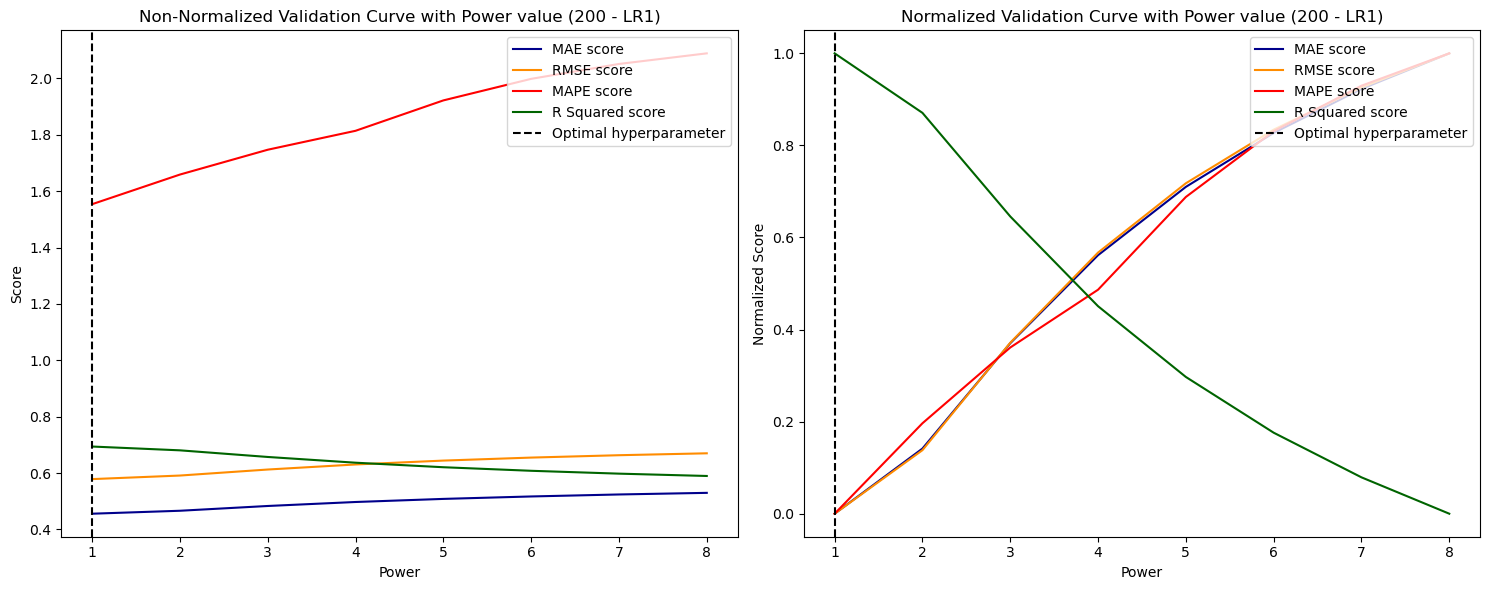

In [5]:
power = 1
df = pd.DataFrame(cv_score_list_200_power).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve with Power value (200 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve with Power value (200 - LR1)")

plt.tight_layout()
plt.show()

In [6]:
# Initialize an empty dictionary for storing scores
cv_score_list_200_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_200_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_200_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_200_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.500478,0.461423,0.455868,0.455812,0.458489,0.463346,0.465308,0.468717,0.472536,0.475820
Validation Score RMSE,0.632008,0.585714,0.577824,0.578544,0.581533,0.586950,0.590799,0.596725,0.601425,0.605976
Validation Score MAPE,1.995632,1.556848,1.518778,1.553744,1.585234,1.589818,1.613424,1.595049,1.615287,1.602603
Validation Score R Squared,0.634924,0.686448,0.694839,0.694078,0.690908,0.685124,0.680981,0.674548,0.669401,0.664379


The smallest Validation Score MAE is 0.4558115648390004, found in n_neighbors 8.
The smallest Validation Score RMSE is 0.577824113414488, found in n_neighbors 6.
The smallest Validation Score MAPE is 1.5187782918580697, found in n_neighbors 6.
The largest Validation Score R Squared is 0.6948388255390481, found in n_neighbors 6.
Validation Computation Time: 0.44 seconds


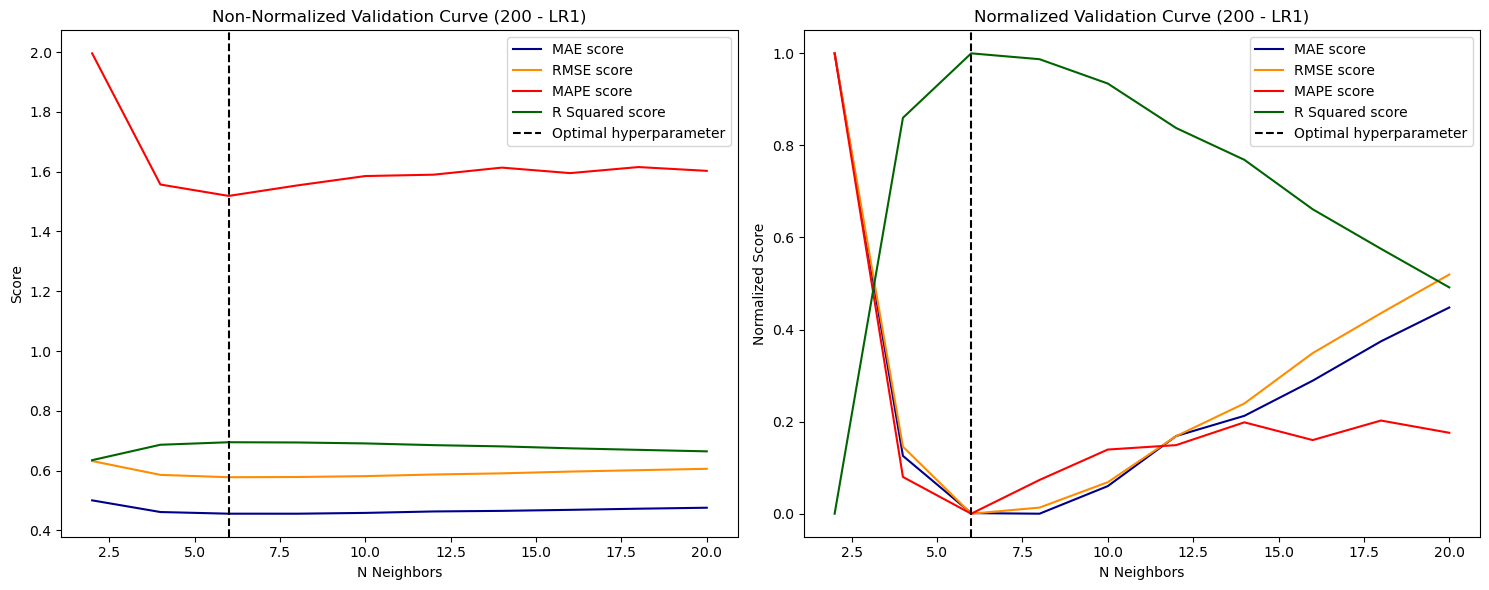

In [7]:
n_neighbors = 6
df = pd.DataFrame(cv_score_list_200_n).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve (200 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve (200 - LR1)")

plt.tight_layout()
plt.show()

# 400 points calibration

In [8]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal400.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal400.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal400.csv')

In [9]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_400_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.436013,0.459946,0.485351,0.503325,0.515822,0.524692,0.531248,0.536153
Validation Score RMSE,0.553839,0.581610,0.612135,0.634743,0.650581,0.661846,0.670087,0.676296
Validation Score MAPE,1.636350,1.682333,1.713251,1.724699,1.727713,1.744273,1.754359,1.758364
Validation Score R Squared,0.719647,0.690827,0.657522,0.631757,0.613152,0.599639,0.589606,0.581966


The smallest Validation Score MAE is 0.4360134528072176, found in power 1.
The smallest Validation Score RMSE is 0.5538391237668302, found in power 1.
The smallest Validation Score MAPE is 1.6363503490833442, found in power 1.
The largest Validation Score R Squared is 0.7196469937291419, found in power 1.
Validation Computation Time: 0.38 seconds


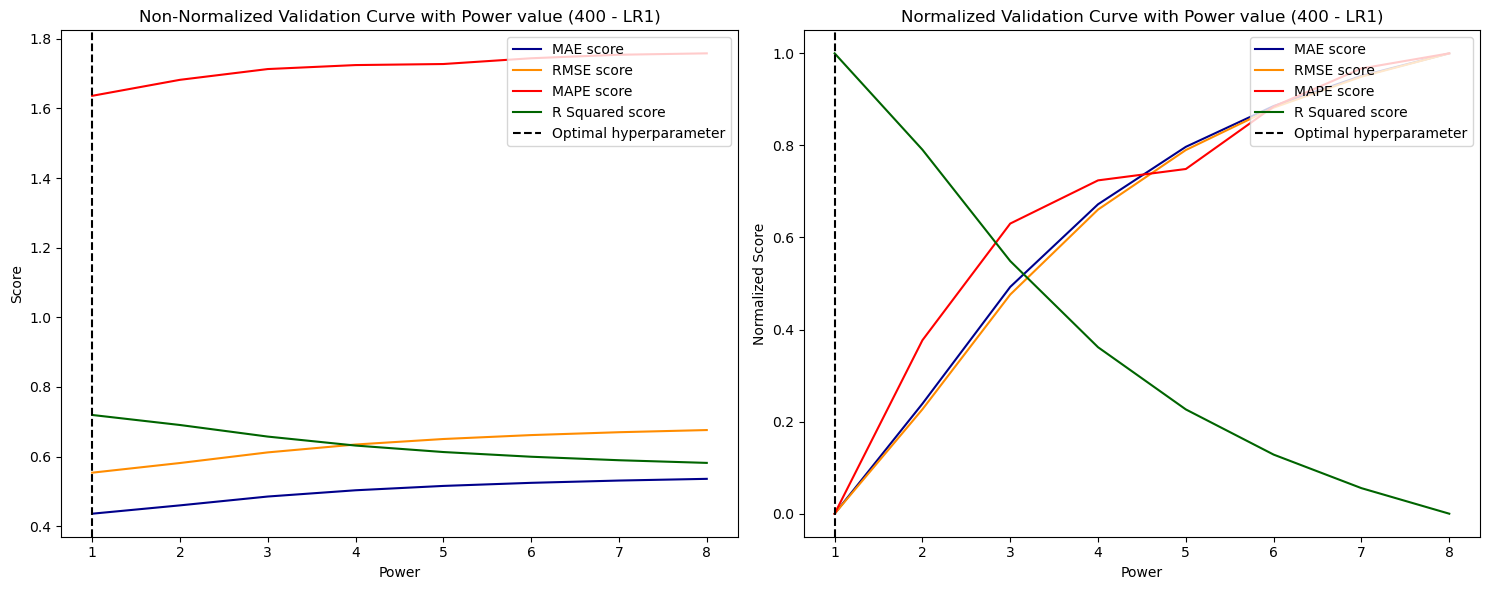

In [10]:
power = 1
df = pd.DataFrame(cv_score_list_400_power).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve with Power value (400 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve with Power value (400 - LR1)")

plt.tight_layout()
plt.show()

In [11]:
# Initialize an empty dictionary for storing scores
cv_score_list_400_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_400_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_400_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_400_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.504368,0.460081,0.443825,0.436013,0.435659,0.435227,0.435970,0.434997,0.437302,0.439822
Validation Score RMSE,0.633491,0.582192,0.563092,0.553839,0.551181,0.550777,0.551008,0.550749,0.552991,0.556067
Validation Score MAPE,1.865560,1.701664,1.683474,1.636350,1.594154,1.565761,1.618848,1.608504,1.623199,1.580598
Validation Score R Squared,0.633209,0.690208,0.710201,0.719647,0.722332,0.722739,0.722506,0.722766,0.720505,0.717387


The smallest Validation Score MAE is 0.43499693939914436, found in n_neighbors 16.
The smallest Validation Score RMSE is 0.5507494631743436, found in n_neighbors 16.
The smallest Validation Score MAPE is 1.5657607657969634, found in n_neighbors 12.
The largest Validation Score R Squared is 0.7227662372358845, found in n_neighbors 16.
Validation Computation Time: 0.56 seconds


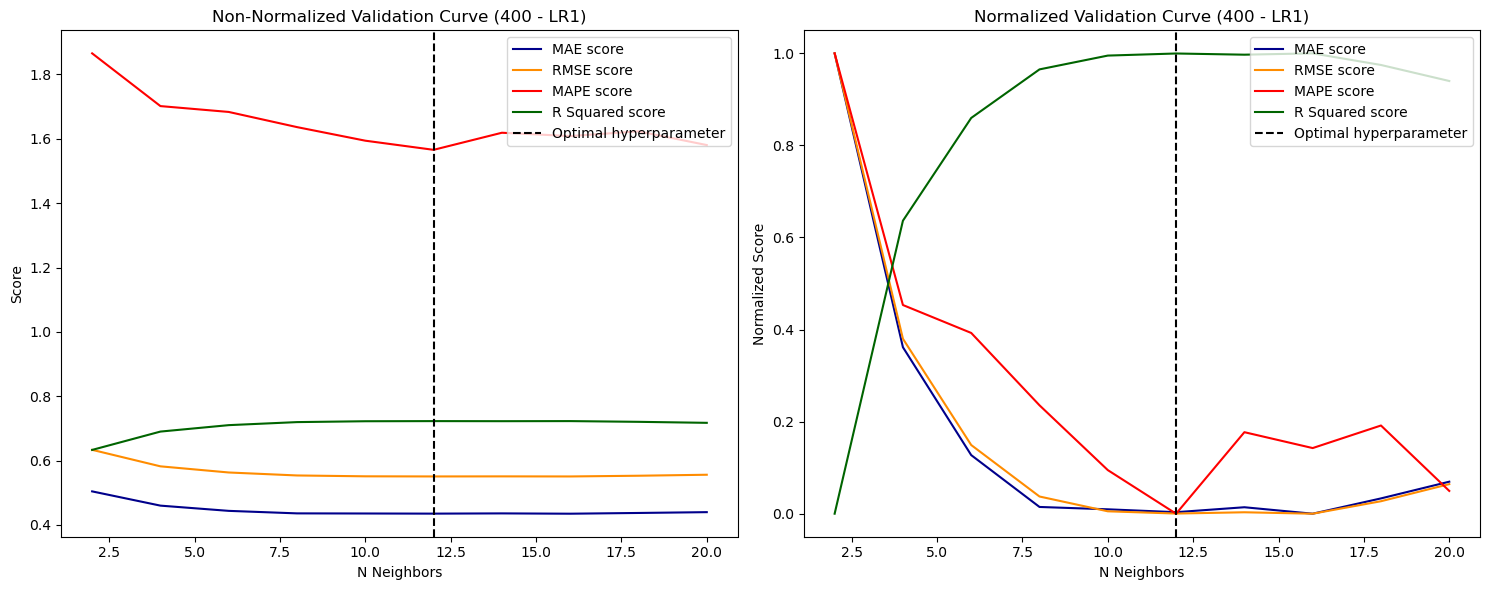

In [13]:
n_neighbors = 12
df = pd.DataFrame(cv_score_list_400_n).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve (400 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve (400 - LR1)")

plt.tight_layout()
plt.show()

# 600 points calibration

In [14]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal600.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal600.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal600.csv')

In [15]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_600_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.430981,0.452872,0.477424,0.496062,0.509166,0.518462,0.525147,0.530227
Validation Score RMSE,0.546995,0.572895,0.603094,0.626433,0.643006,0.654788,0.663334,0.669679
Validation Score MAPE,1.628246,1.641897,1.678906,1.720717,1.762424,1.800448,1.831804,1.857503
Validation Score R Squared,0.726534,0.700023,0.667564,0.641336,0.622107,0.608132,0.597836,0.590107


The smallest Validation Score MAE is 0.4309807849425024, found in power 1.
The smallest Validation Score RMSE is 0.5469946051627668, found in power 1.
The smallest Validation Score MAPE is 1.62824615135814, found in power 1.
The largest Validation Score R Squared is 0.726533557767904, found in power 1.
Validation Computation Time: 0.42 seconds


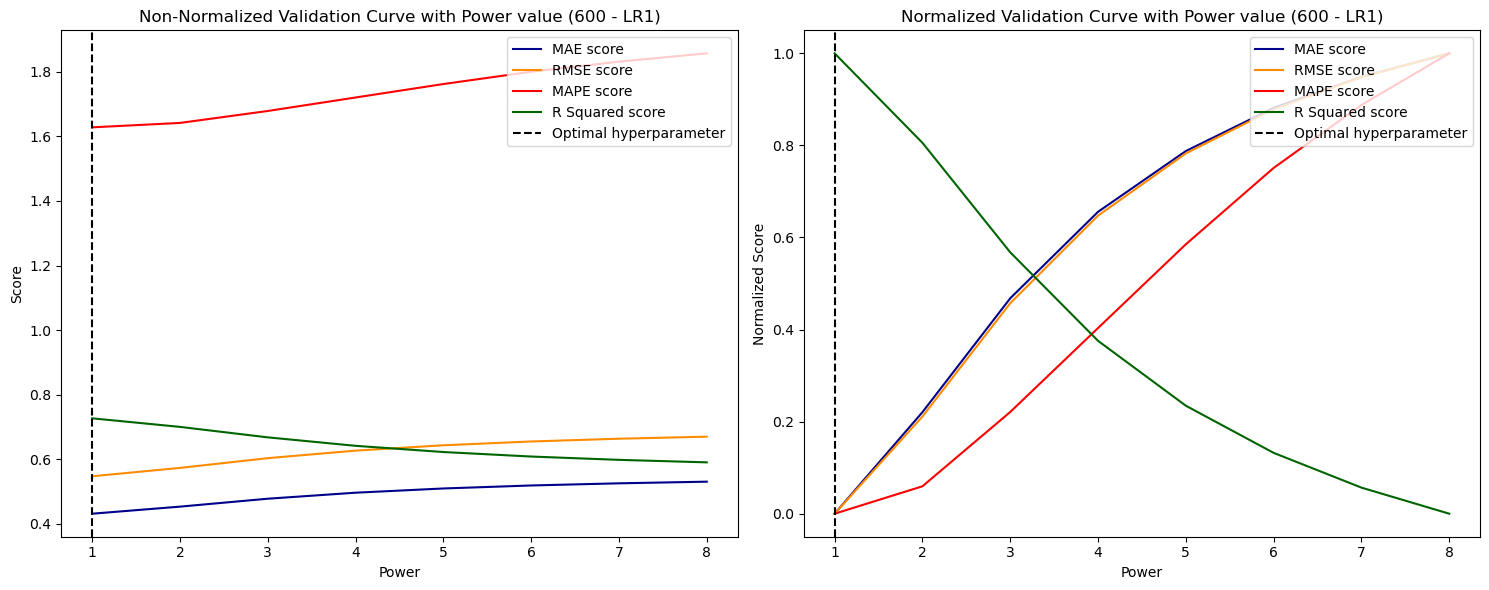

In [16]:
power = 1
df = pd.DataFrame(cv_score_list_600_power).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve with Power value (600 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve with Power value (600 - LR1)")

plt.tight_layout()
plt.show()

In [17]:
# Initialize an empty dictionary for storing scores
cv_score_list_600_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_600_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_600_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_600_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.497445,0.453441,0.439535,0.430981,0.428283,0.427705,0.427999,0.427838,0.427273,0.426646
Validation Score RMSE,0.627399,0.572277,0.555462,0.546995,0.542554,0.541109,0.540407,0.539233,0.538987,0.539578
Validation Score MAPE,1.777216,1.551775,1.543661,1.628246,1.587223,1.585408,1.614068,1.617223,1.664373,1.630670
Validation Score R Squared,0.640230,0.700670,0.718001,0.726534,0.730956,0.732387,0.733081,0.734240,0.734482,0.733899


The smallest Validation Score MAE is 0.4266463017158832, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.5389870113177336, found in n_neighbors 18.
The smallest Validation Score MAPE is 1.5436610439054155, found in n_neighbors 6.
The largest Validation Score R Squared is 0.7344816420748881, found in n_neighbors 18.
Validation Computation Time: 0.45 seconds


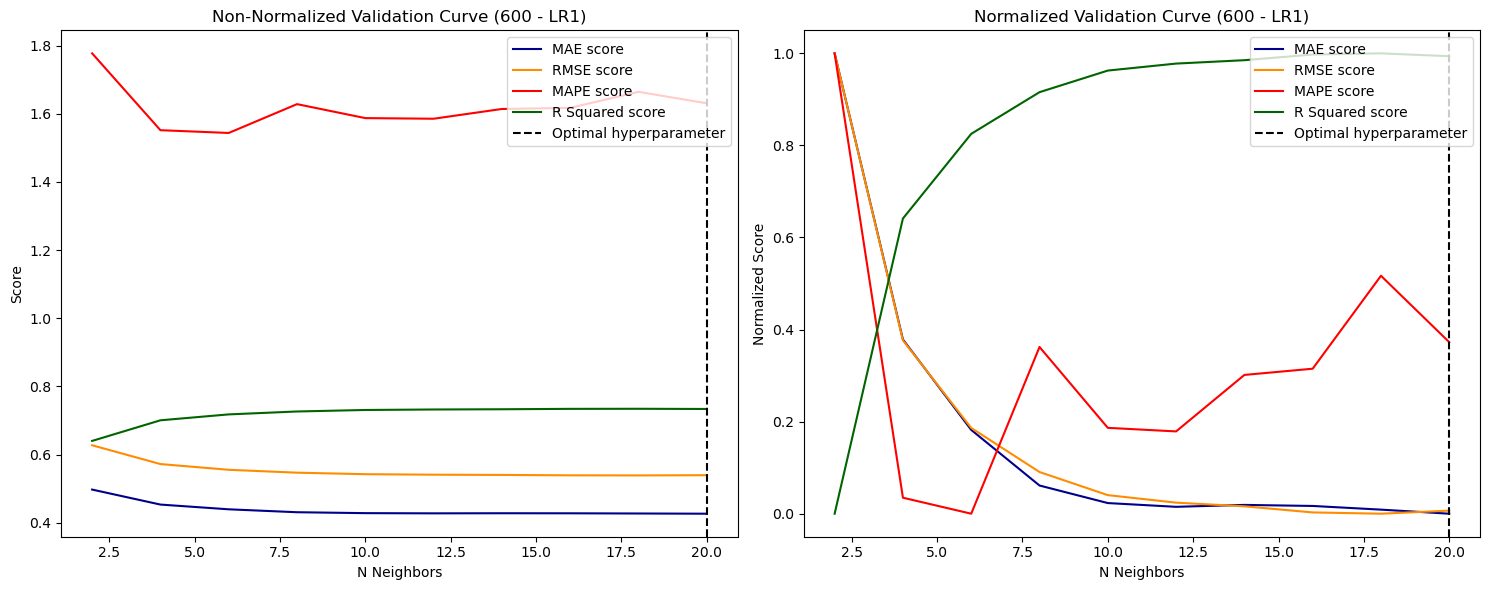

In [19]:
n_neighbors = 20
df = pd.DataFrame(cv_score_list_600_n).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve (600 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve (600 - LR1)")

plt.tight_layout()
plt.show()

# 800 points calibration

In [24]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal800.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal800.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal800.csv')

In [25]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in  cv_score_list_800_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.435541,0.456019,0.479568,0.497467,0.510250,0.519688,0.526706,0.532145
Validation Score RMSE,0.549737,0.575448,0.605979,0.630333,0.648159,0.661194,0.670858,0.678131
Validation Score MAPE,1.646083,1.733108,1.819322,1.877062,1.911699,1.942043,1.965074,1.982176
Validation Score R Squared,0.723785,0.697343,0.664376,0.636857,0.616027,0.600428,0.588661,0.579694


The smallest Validation Score MAE is 0.4355412164886416, found in power 1.
The smallest Validation Score RMSE is 0.5497370769679412, found in power 1.
The smallest Validation Score MAPE is 1.6460831219136416, found in power 1.
The largest Validation Score R Squared is 0.7237845212102381, found in power 1.
Validation Computation Time: 0.41 seconds


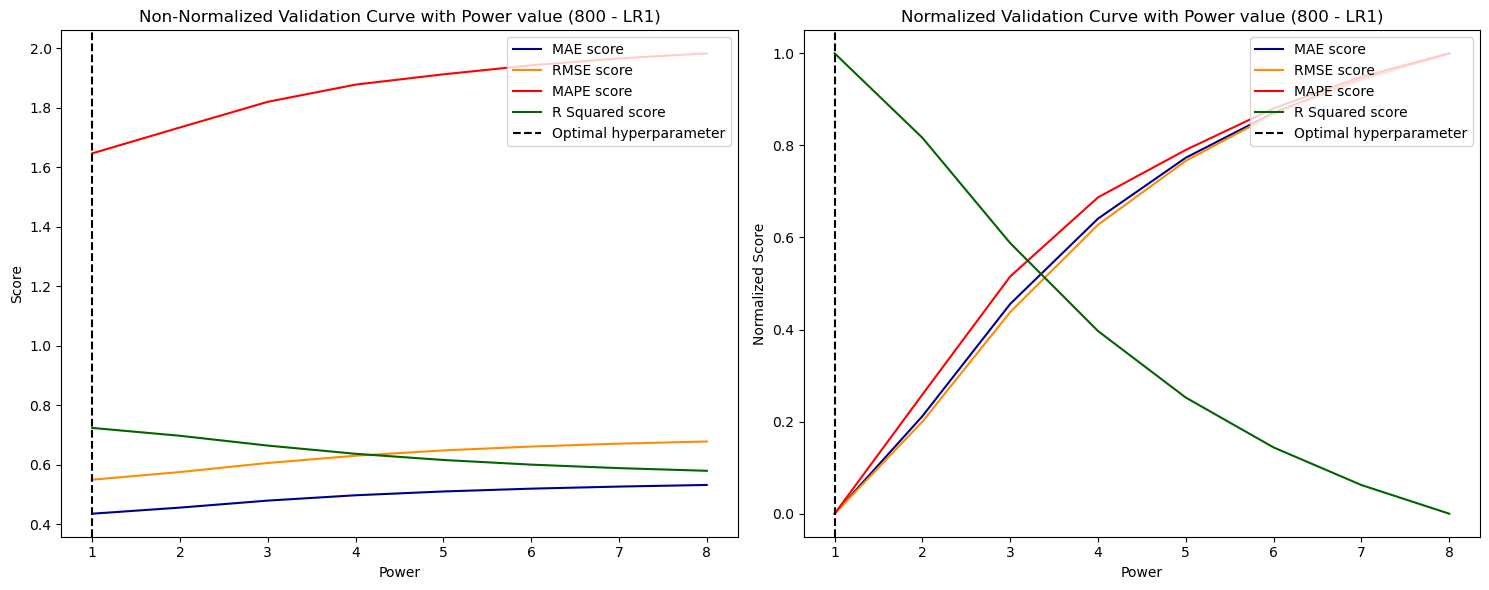

In [26]:
power = 1
df = pd.DataFrame(cv_score_list_800_power).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve with Power value (800 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve with Power value (800 - LR1)")

plt.tight_layout()
plt.show()

In [27]:
# Initialize an empty dictionary for storing scores
cv_score_list_800_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_800_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_800_n))

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_800_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.506399,0.457384,0.443827,0.435541,0.430241,0.427122,0.425922,0.425800,0.425854,0.425492
Validation Score RMSE,0.642011,0.579471,0.559902,0.549737,0.542978,0.538947,0.536513,0.535985,0.535741,0.535803
Validation Score MAPE,2.019943,1.805648,1.700674,1.646083,1.650508,1.606554,1.615563,1.602497,1.613258,1.627045
Validation Score R Squared,0.623277,0.693097,0.713475,0.723785,0.730535,0.734521,0.736914,0.737431,0.737670,0.737609


The smallest Validation Score MAE is 0.42549229145821793, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.5357412919022086, found in n_neighbors 18.
The smallest Validation Score MAPE is 1.602497454043134, found in n_neighbors 16.
The largest Validation Score R Squared is 0.7376698571734617, found in n_neighbors 18.
Validation Computation Time: 0.46 seconds


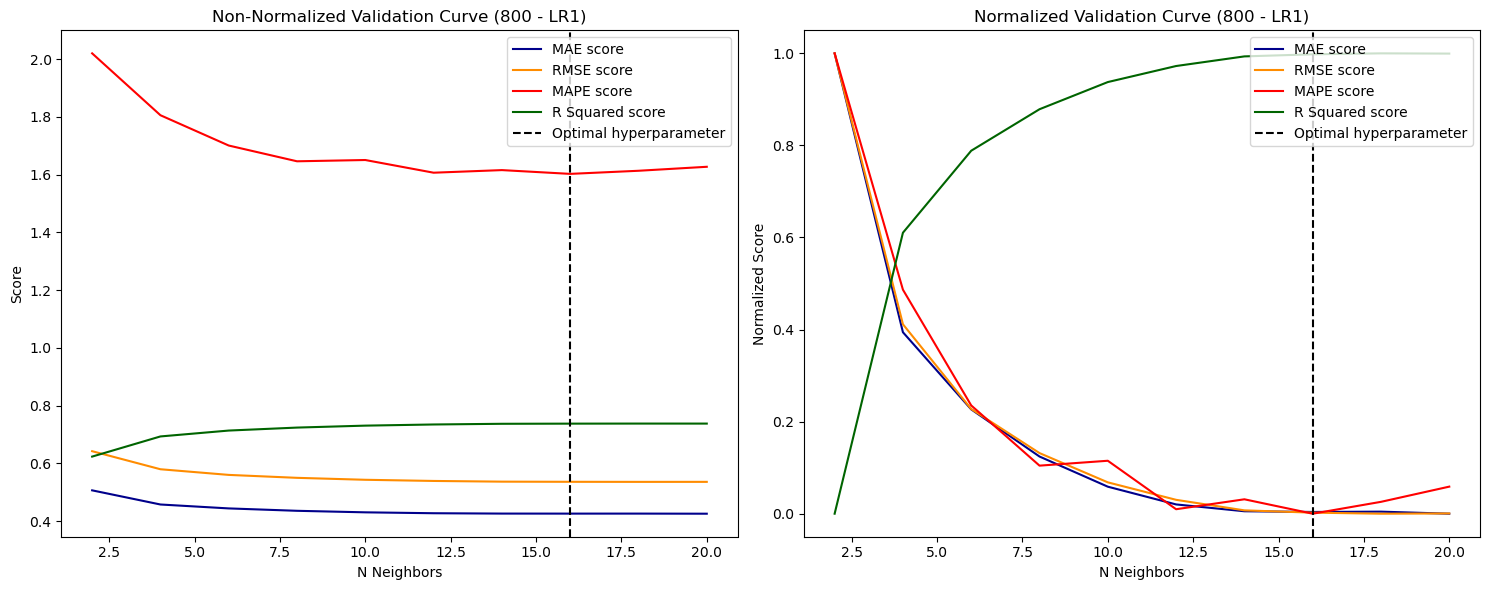

In [29]:
n_neighbors = 16
df = pd.DataFrame(cv_score_list_800_n).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve (800 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve (800 - LR1)")

plt.tight_layout()
plt.show()

# 1000 points calibration

In [30]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal1000.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal1000.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal1000.csv')

In [31]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.431367,0.450764,0.475450,0.494414,0.508136,0.518072,0.525418,0.531062
Validation Score RMSE,0.546659,0.571572,0.603151,0.629061,0.647954,0.661575,0.671519,0.678887
Validation Score MAPE,1.735034,1.795295,1.854368,1.888225,1.910231,1.927681,1.940724,1.950922
Validation Score R Squared,0.726869,0.701407,0.667502,0.638321,0.616270,0.599967,0.587850,0.578757


The smallest Validation Score MAE is 0.4313674677664515, found in power 1.
The smallest Validation Score RMSE is 0.5466589773928207, found in power 1.
The smallest Validation Score MAPE is 1.7350340970569544, found in power 1.
The largest Validation Score R Squared is 0.7268690447104553, found in power 1.
Validation Computation Time: 0.40 seconds


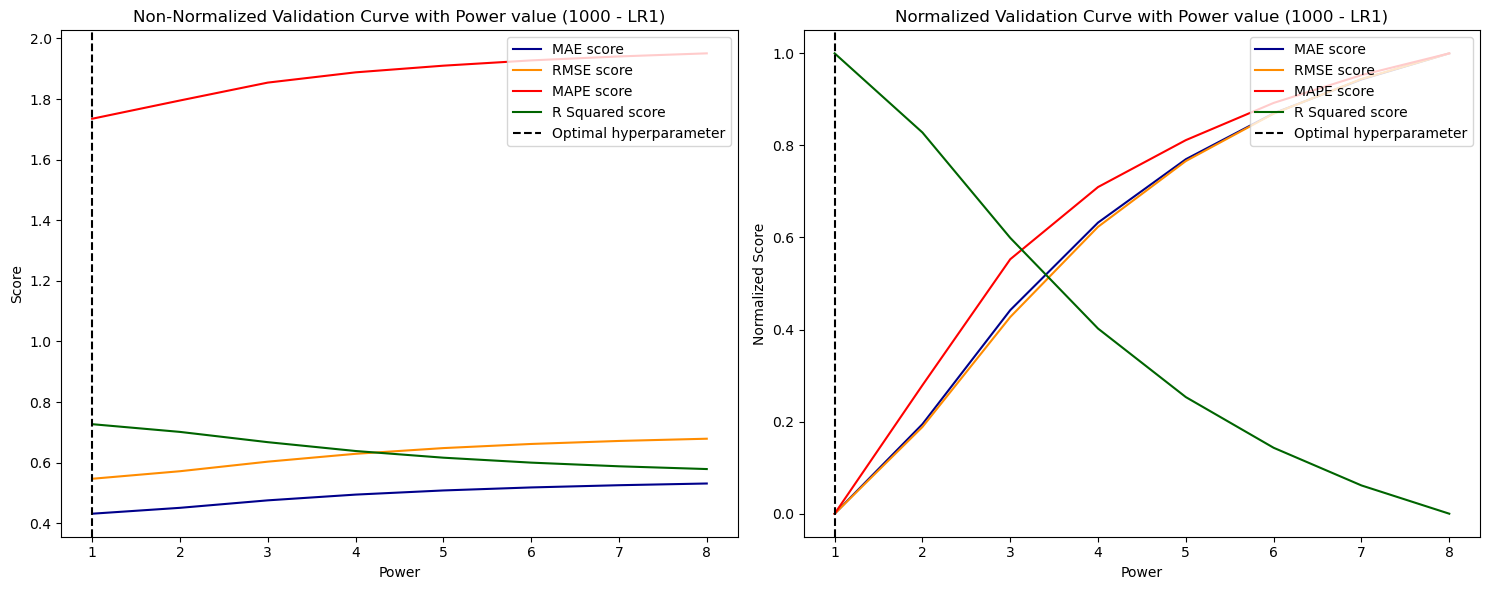

In [32]:
power = 1
df = pd.DataFrame(cv_score_list_1000_power).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve with Power value (1000 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve with Power value (1000 - LR1)")

plt.tight_layout()
plt.show()

In [33]:
# Initialize an empty dictionary for storing scores
cv_score_list_1000_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.501676,0.455262,0.436418,0.431367,0.426665,0.423846,0.422510,0.422378,0.422332,0.422730
Validation Score RMSE,0.636234,0.577290,0.554850,0.546659,0.541387,0.537430,0.535056,0.533893,0.533108,0.532936
Validation Score MAPE,2.008675,1.796994,1.763883,1.735034,1.646112,1.646346,1.659117,1.649369,1.632576,1.661514
Validation Score R Squared,0.630026,0.695403,0.718623,0.726869,0.732111,0.736014,0.738340,0.739477,0.740243,0.740410


The smallest Validation Score MAE is 0.42233176210628803, found in n_neighbors 18.
The smallest Validation Score RMSE is 0.5329360916522028, found in n_neighbors 20.
The smallest Validation Score MAPE is 1.6325760317469253, found in n_neighbors 18.
The largest Validation Score R Squared is 0.7404098437924206, found in n_neighbors 20.
Validation Computation Time: 0.45 seconds


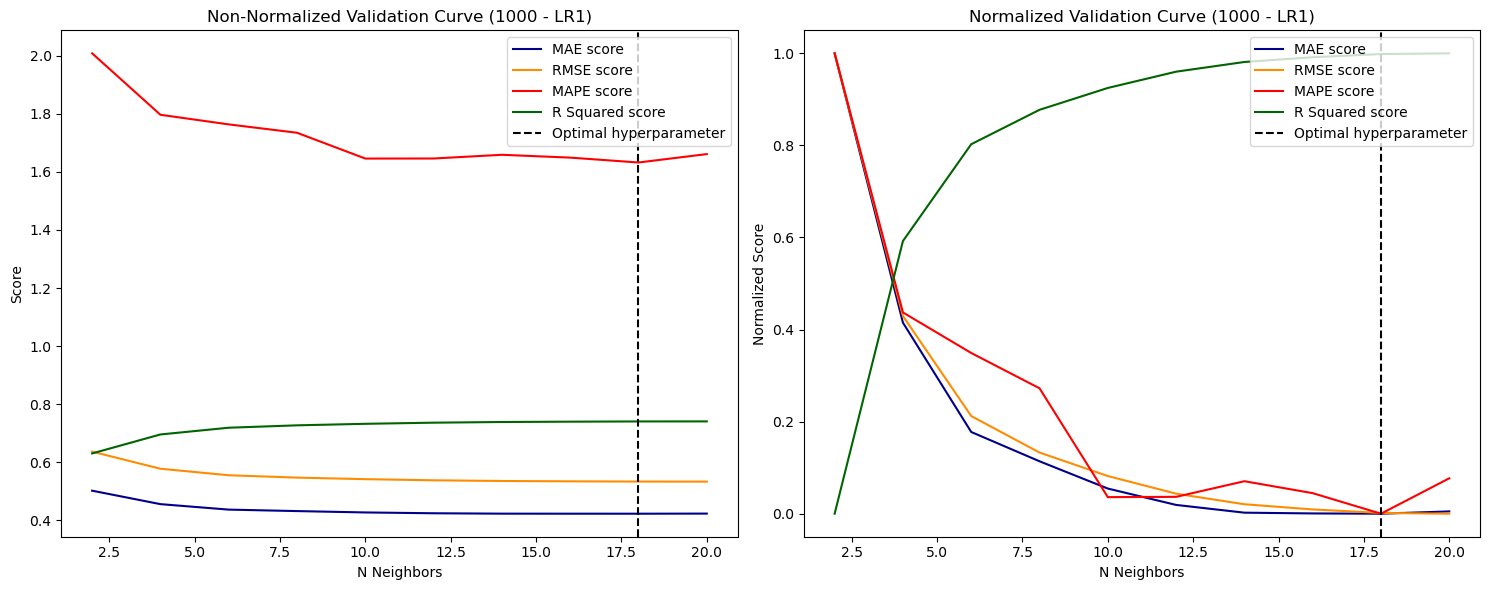

In [34]:
n_neighbors = 18
df = pd.DataFrame(cv_score_list_1000_n).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve (1000 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve (1000 - LR1)")

plt.tight_layout()
plt.show()

# 1500 points calibration

In [35]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal1500.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal1500.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal1500.csv')

In [36]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.430159,0.447655,0.471373,0.490678,0.504908,0.515021,0.521988,0.527191
Validation Score RMSE,0.541515,0.563200,0.592853,0.618446,0.637151,0.650423,0.659950,0.666908
Validation Score MAPE,1.740083,1.778496,1.826456,1.854624,1.871162,1.880886,1.893068,1.908845
Validation Score R Squared,0.731985,0.710090,0.678758,0.650424,0.628958,0.613339,0.601929,0.593492


The smallest Validation Score MAE is 0.43015892735345573, found in power 1.
The smallest Validation Score RMSE is 0.5415146024321312, found in power 1.
The smallest Validation Score MAPE is 1.740082747490223, found in power 1.
The largest Validation Score R Squared is 0.7319854948646949, found in power 1.
Validation Computation Time: 0.40 seconds


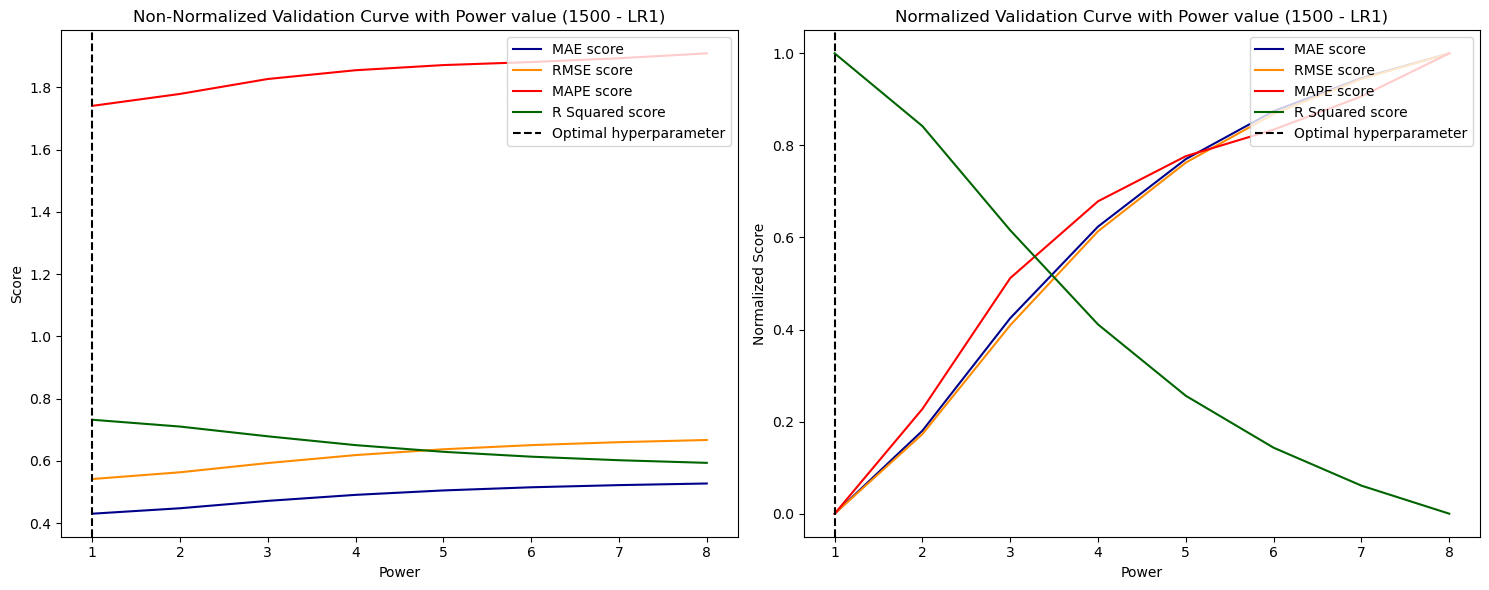

In [37]:
power = 1
df = pd.DataFrame(cv_score_list_1500_power).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve with Power value (1500 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve with Power value (1500 - LR1)")

plt.tight_layout()
plt.show()

In [38]:
# Initialize an empty dictionary for storing scores
cv_score_list_1500_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_1500_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_1500_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_1500_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.496265,0.457329,0.439870,0.430159,0.424172,0.421054,0.419963,0.418590,0.416607,0.416407
Validation Score RMSE,0.625570,0.575717,0.553955,0.541515,0.533672,0.530261,0.528543,0.527313,0.524810,0.524083
Validation Score MAPE,1.905327,1.717277,1.795391,1.740083,1.686181,1.681565,1.648816,1.673123,1.627588,1.648828
Validation Score R Squared,0.642324,0.697061,0.719530,0.731985,0.739692,0.743009,0.744672,0.745859,0.748266,0.748963


The smallest Validation Score MAE is 0.4164073269682226, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.5240827831623207, found in n_neighbors 20.
The smallest Validation Score MAPE is 1.627588421907586, found in n_neighbors 18.
The largest Validation Score R Squared is 0.7489629978433124, found in n_neighbors 20.
Validation Computation Time: 0.48 seconds


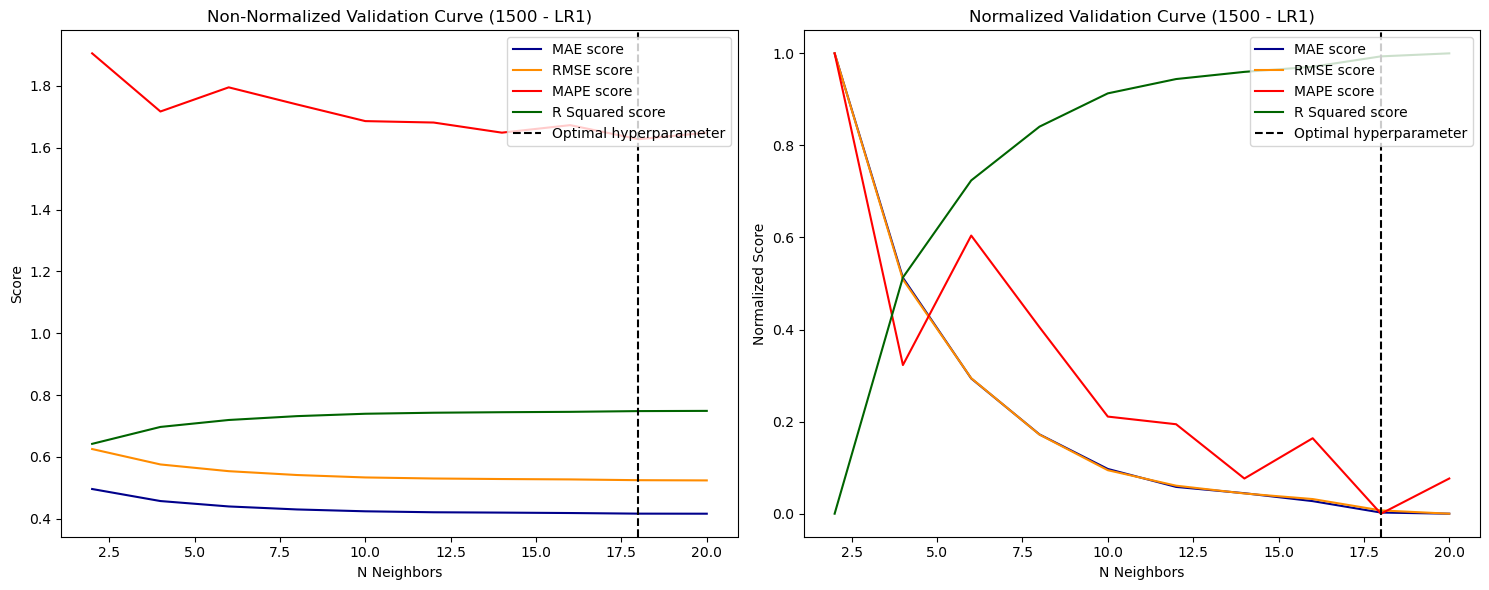

In [40]:
n_neighbors = 18
df = pd.DataFrame(cv_score_list_1500_n).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve (1500 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve (1500 - LR1)")

plt.tight_layout()
plt.show()

# 2000 points calibration

In [41]:
# Specify the relative path to the CSV file
file_path = 'Synthetic Data/LR1/'  # Adjust the path according to your directory structure
#cal_SR0_input_randomfield_cal1000
# Use pandas to read the CSV file into a DataFrame
cal_df = pd.read_csv(f'{file_path}cal_LR1_input_randomfield_cal2000.csv')
val_df = pd.read_csv(f'{file_path}val_LR1_input_randomfield_cal2000.csv')
test_df = pd.read_csv(f'{file_path}test_LR1_input_randomfield_cal2000.csv')

In [42]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_power = {}
powers_list = [1, 2, 3, 4, 5, 6, 7, 8]

start_time = time.time()

# For each hyperparameter value
for power in powers_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=power)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_power[power] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_power))

# Identifying the best hyperparameter based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_power.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in power {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in power {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,1,2,3,4,5,6,7,8
Validation Score MAE,0.425591,0.439310,0.460312,0.479051,0.493671,0.504621,0.512425,0.518060
Validation Score RMSE,0.536245,0.553861,0.579901,0.604185,0.622840,0.636406,0.646241,0.653434
Validation Score MAPE,1.591003,1.581220,1.643227,1.690907,1.726047,1.752425,1.773324,1.788779
Validation Score R Squared,0.737176,0.719625,0.692641,0.666361,0.645439,0.629825,0.618295,0.609752


The smallest Validation Score MAE is 0.42559125640458273, found in power 1.
The smallest Validation Score RMSE is 0.5362454265294276, found in power 1.
The smallest Validation Score MAPE is 1.5812195850914668, found in power 2.
The largest Validation Score R Squared is 0.7371759175257036, found in power 1.
Validation Computation Time: 0.53 seconds


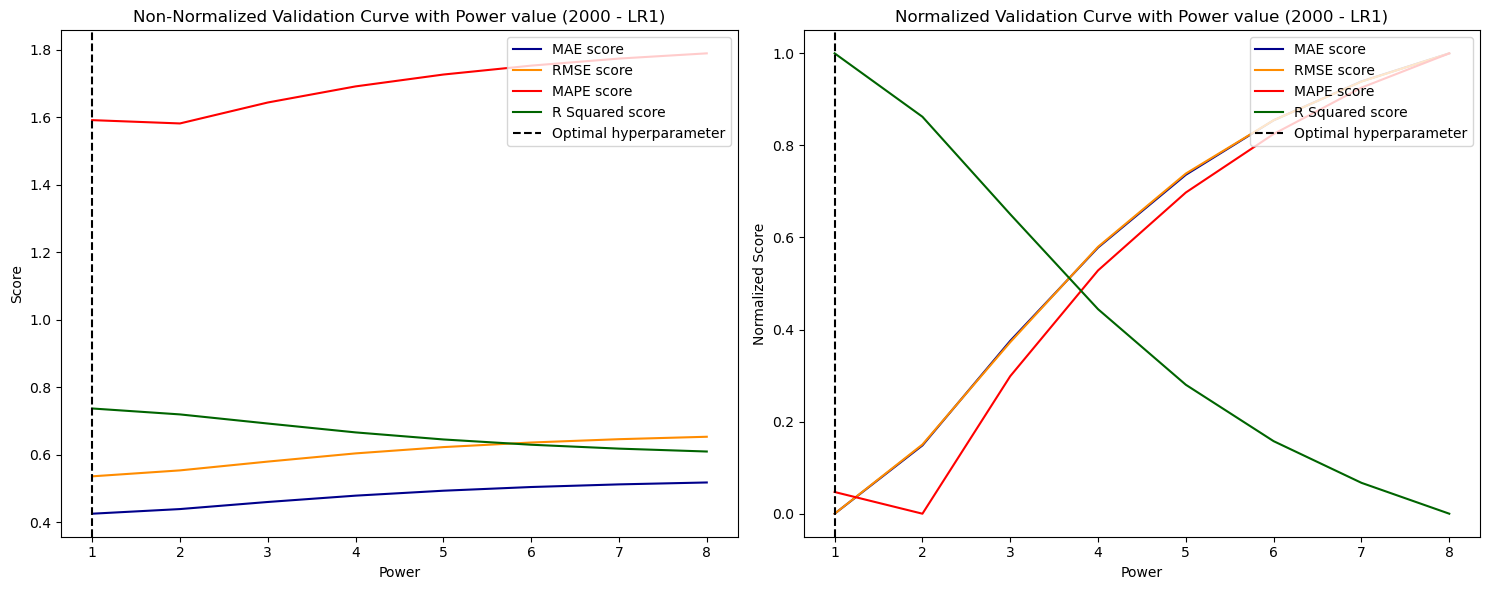

In [48]:
power = 1
df = pd.DataFrame(cv_score_list_2000_power).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(powers_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(powers_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(powers_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(powers_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve with Power value (2000 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(powers_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(powers_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(powers_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(powers_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(power, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve with Power value (2000 - LR1)")

plt.tight_layout()
plt.show()

In [49]:
# Initialize an empty dictionary for storing scores
cv_score_list_2000_n = {}
n_neighbors_list = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

start_time = time.time()

# For each number of neighbors
for n_neighbors in n_neighbors_list:
    
    # Prepare the training data
    combined_array_train = np.array([list(pair) for pair in zip(cal_df['x'], cal_df['y'])])
    idw_model = ShepardIDWInterpolator(combined_array_train, cal_df['z'])
    
    # Predict on the validation set
    combined_array_validation = np.array([list(pair) for pair in zip(val_df['x'], val_df['y'])])
    z_pred_validation = idw_model.__call__(combined_array_validation, power=1, n_neighbors=n_neighbors)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(val_df['z'], z_pred_validation))
    mae = mean_absolute_error(val_df['z'], z_pred_validation)
    mape = mean_absolute_percentage_error(val_df['z'], z_pred_validation)
    r2 = r2_score(val_df['z'], z_pred_validation)
    
    # Store the scores
    cv_score_list_2000_n[n_neighbors] = {
        "Validation Score MAE": mae,
        "Validation Score RMSE": rmse,
        "Validation Score MAPE": mape,
        "Validation Score R Squared": r2
    }

end_time = time.time()
display(pd.DataFrame(cv_score_list_2000_n))  # Transposed for better readability

# Identifying the best number of neighbors based on a specific metric
best_scores = {
    "Validation Score MAE": {"value": float('inf'), "model": None},
    "Validation Score RMSE": {"value": float('inf'), "model": None},
    "Validation Score MAPE": {"value": float('inf'), "model": None},
    "Validation Score R Squared": {"value": float('-inf'), "model": None}
}

for model, scores in cv_score_list_2000_n.items():
    for score_type, score_value in scores.items():
        if score_type == "Validation Score R Squared":
            if score_value > best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model
        else:
            if score_value < best_scores[score_type]["value"]:
                best_scores[score_type]["value"] = score_value
                best_scores[score_type]["model"] = model

for score_type, info in best_scores.items():
    if score_type == "Validation Score R Squared":
        print(f"The largest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")
    else:
        print(f"The smallest {score_type} is {info['value']}, found in n_neighbors {info['model']}.")

print(f"Validation Computation Time: {end_time - start_time:.2f} seconds")


,2,4,6,8,10,12,14,16,18,20
Validation Score MAE,0.486530,0.448360,0.433712,0.425591,0.419202,0.417034,0.414853,0.413205,0.412065,0.410892
Validation Score RMSE,0.614134,0.565927,0.546389,0.536245,0.528582,0.524765,0.522106,0.520240,0.519697,0.518497
Validation Score MAPE,1.789290,1.639256,1.576576,1.591003,1.599350,1.614007,1.582652,1.569747,1.551929,1.582765
Validation Score R Squared,0.655282,0.707275,0.727138,0.737176,0.744634,0.748309,0.750853,0.752631,0.753147,0.754285


The smallest Validation Score MAE is 0.4108915966015332, found in n_neighbors 20.
The smallest Validation Score RMSE is 0.5184973519710905, found in n_neighbors 20.
The smallest Validation Score MAPE is 1.5519288350742895, found in n_neighbors 18.
The largest Validation Score R Squared is 0.7542853561240808, found in n_neighbors 20.
Validation Computation Time: 0.46 seconds


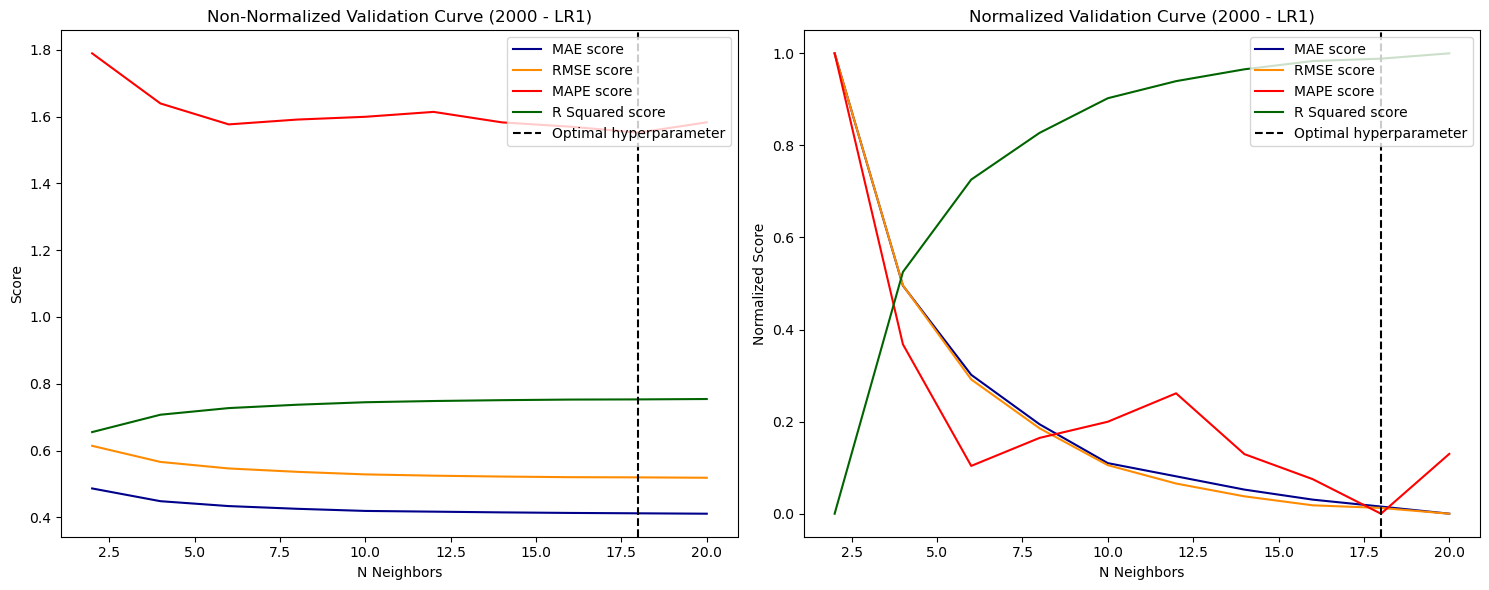

In [51]:
n_neighbors = 18
df = pd.DataFrame(cv_score_list_2000_n).T

# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(n_neighbors_list, df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(n_neighbors_list, df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(n_neighbors_list, df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(n_neighbors_list, df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[0].set_xlabel('N Neighbors')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation Curve (2000 - LR1)")

# Plot normalized data on the second subplot
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(n_neighbors_list, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].axvline(n_neighbors, c='k', ls='--', label="Optimal hyperparameter")
ax[1].set_xlabel('N Neighbors')
ax[1].set_ylabel('Normalized Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation Curve (2000 - LR1)")

plt.tight_layout()
plt.show()

## Validation score as calibration set size increases

In [60]:
def calculate_means(data_structures):
    all_means = {}
    for structure_id, data in enumerate(data_structures, 1):
        means = {key: sum(d[key] for d in data.values()) / len(data) for key in data[next(iter(data))]}
        all_means[f"Structure {structure_id}"] = means
    return all_means

# List of data structures
data_structures_n = [cv_score_list_200_n, cv_score_list_400_n, cv_score_list_600_n, cv_score_list_800_n,cv_score_list_1000_n,cv_score_list_1500_n, cv_score_list_2000_n]
data_structures_power = [cv_score_list_200_power, cv_score_list_400_power, cv_score_list_600_power,cv_score_list_800_power,cv_score_list_1000_power,cv_score_list_1500_power, cv_score_list_2000_power]

# Calculate means
all_means_n = calculate_means(data_structures_n)
all_means_power = calculate_means(data_structures_power)

In [61]:
new_keys = [200, 400, 600, 800, 1000, 1500, 2000]

# Function to replace keys
def replace_keys(structures, new_keys):
    # Make sure there are enough new keys for the structures
    if len(new_keys) < len(structures):
        raise ValueError("Not enough new keys for the number of structures")

    # New dictionary to store replaced key structures
    replaced_structures = {}

    # Use zip to iterate over both the items in structures and the new_keys simultaneously
    for new_key, (old_key, value) in zip(new_keys, structures.items()):
        replaced_structures[new_key] = value

    return replaced_structures

all_means_n = replace_keys(all_means_n, new_keys)
all_means_power = replace_keys(all_means_power, new_keys)

In [62]:
cal_size = [200, 400, 600, 800, 1000, 1500, 2000]
all_means_power_df = pd.DataFrame(all_means_power).T
all_means_n_df = pd.DataFrame(all_means_n).T
all_means_n_df

,Validation Score MAE,Validation Score RMSE,Validation Score MAPE,Validation Score R Squared
200,0.467780,0.593750,1.622642,0.677563
400,0.446327,0.564539,1.647811,0.708150
600,0.438715,0.554400,1.619986,0.718448
800,0.440358,0.555709,1.688777,0.716831
1000,0.436518,0.552884,1.719962,0.719752
1500,0.434042,0.546544,1.712418,0.726136
2000,0.428144,0.539658,1.609657,0.733073


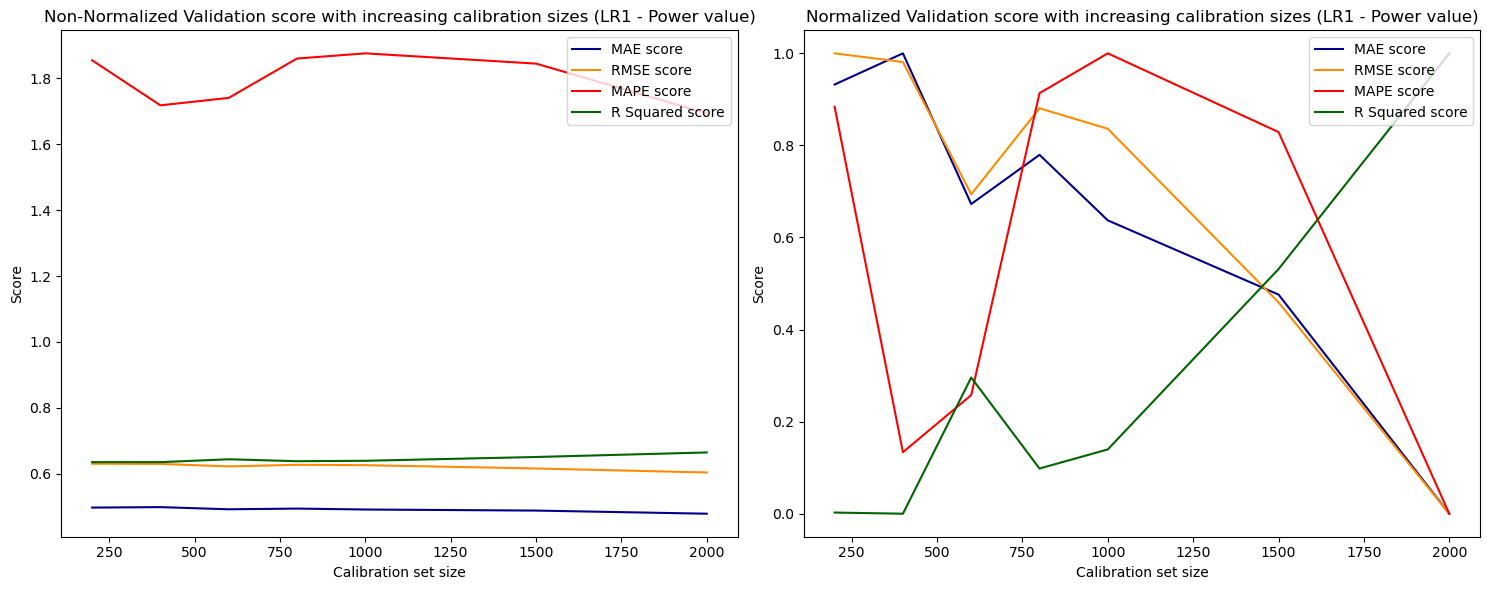

In [63]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_power_df), columns=all_means_power_df.columns, index=all_means_power_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_power_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_power_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation score with increasing calibration sizes (LR1 - Power value)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation score with increasing calibration sizes (LR1 - Power value)")

plt.tight_layout()
plt.show()

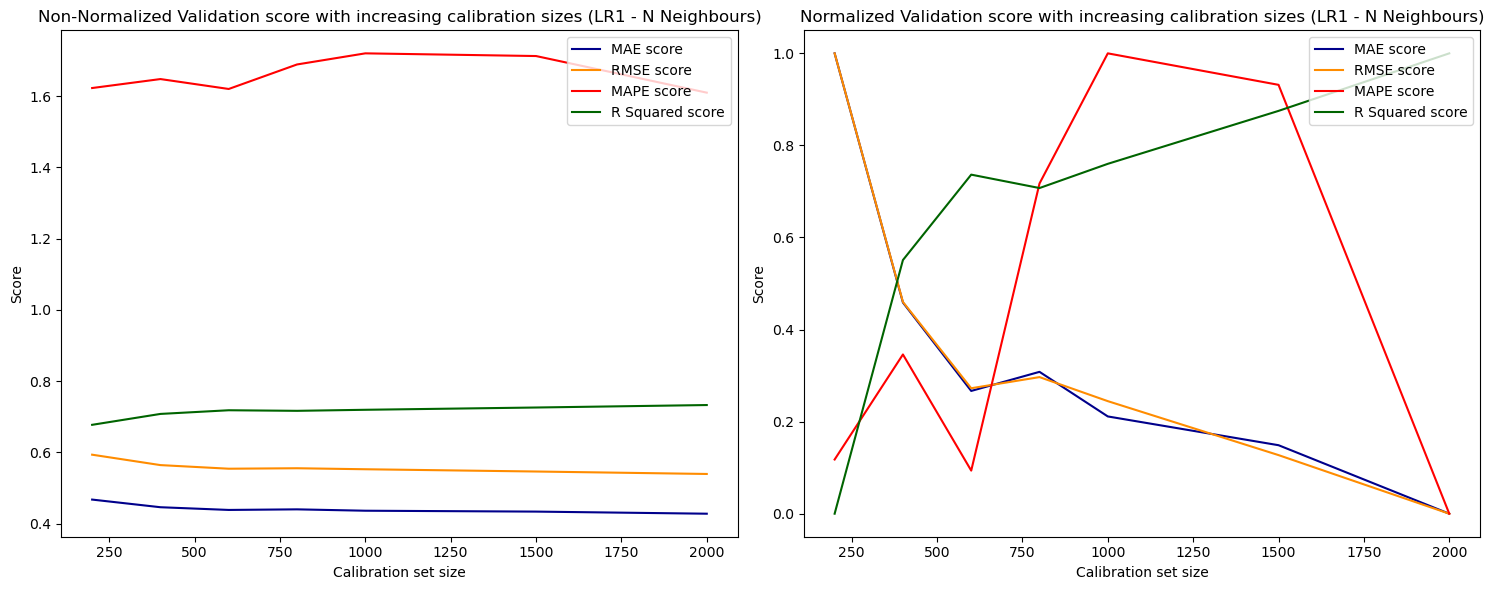

In [64]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Fit and transform the data for normalization
normalized_df = pd.DataFrame(scaler.fit_transform(all_means_n_df), columns=all_means_n_df.columns, index=all_means_n_df.index)

# Create subplots side by side
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Plot non-normalized data on the first subplot
ax[0].plot(cal_size, all_means_n_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[0].plot(cal_size, all_means_n_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[0].set_xlabel('Calibration set size')
ax[0].set_ylabel('Score')
ax[0].legend(loc="upper right")
ax[0].set_title("Non-Normalized Validation score with increasing calibration sizes (LR1 - N Neighbours)")

# Plot normalized data on the second subplot
ax[1].plot(cal_size, normalized_df["Validation Score MAE"], color='darkblue', label='MAE score')
ax[1].plot(cal_size, normalized_df["Validation Score RMSE"], color='darkorange', label='RMSE score')
ax[1].plot(cal_size, normalized_df["Validation Score MAPE"], color='red', label='MAPE score')
ax[1].plot(cal_size, normalized_df["Validation Score R Squared"], color='darkgreen', label='R Squared score')
ax[1].set_xlabel('Calibration set size')
ax[1].set_ylabel('Score')
ax[1].legend(loc="upper right")
ax[1].set_title("Normalized Validation score with increasing calibration sizes (LR1 - N Neighbours)")

plt.tight_layout()
plt.show()

## Testing model (Final Performance Metrics)

In [65]:
filenames = ['LR1_input_randomfield_cal200','LR1_input_randomfield_cal400', 'LR1_input_randomfield_cal600',
             'LR1_input_randomfield_cal800', 'LR1_input_randomfield_cal1000', 'LR1_input_randomfield_cal1500', 'LR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
combined_df = pd.DataFrame()
for file in filenames:
    cal_df = pd.read_csv(f'Synthetic Data/LR1/cal_{file}.csv')
    combined_df = pd.concat([cal_df, combined_df], ignore_index=True)

combined_df = pd.concat([val_df, combined_df], ignore_index=True)
combined_df = combined_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

combined_df #All caliration points and validation data points

,x,y,z
0,39,4,-3.592163
1,47,42,-0.513731
2,92,88,-2.327298
3,24,43,-1.637715
4,37,92,-0.105953
...,...,...,...
3995,93,12,0.950197
3996,56,25,0.184283
3997,22,8,-2.189497
3998,38,35,-1.386126


In [66]:
eval_combined_array_coordinates = np.array([list(pair) for pair in zip(combined_df['x'], combined_df['y'])])

start_time = time.time()

idw_model = ShepardIDWInterpolator(eval_combined_array_coordinates, combined_df['z'])

 # Predict at test locations
eval_combined_array_test = np.array([list(pair) for pair in zip(test_df['x'], test_df['y'])])
z_pred_test = idw_model.__call__(eval_combined_array_test, power = 2, n_neighbors = 10)

rmse = np.sqrt(mean_squared_error(test_df['z'], z_pred_test))
mae = mean_absolute_error(test_df['z'], z_pred_test)
mape = mean_absolute_percentage_error(test_df['z'], z_pred_test)
r2 = r2_score(test_df['z'], z_pred_test)

end_time = time.time()

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)
print("R Squared:", r2)
print(f"Testing Computation Time: {end_time - start_time:.2f} seconds")

MAE: 0.42884958126977324
RMSE: 0.5391985752527878
MAPE: 2.1271562718737895
R Squared: 0.7282346508686817
Testing Computation Time: 0.05 seconds


### Plotting Spatial Interpolation of entire area with Model

In [67]:
filenames = ['cal_LR1_input_randomfield_cal200', 'cal_LR1_input_randomfield_cal400', 'cal_LR1_input_randomfield_cal600', 'cal_LR1_input_randomfield_cal800', 'cal_LR1_input_randomfield_cal1000', 'cal_LR1_input_randomfield_cal1500', 'cal_LR1_input_randomfield_cal2000',
            'val_LR1_input_randomfield_cal2000', 'test_LR1_input_randomfield_cal2000']
#cal_SR0_input_randomfield_cal2000.csv
all_df = pd.DataFrame()
for file in filenames:
    df = pd.read_csv(f'Synthetic Data/LR1/{file}.csv')
    all_df = pd.concat([df, all_df], ignore_index=True)

all_df = all_df.drop_duplicates() #The calibration sets are subsets of one another, hence needed

all_df #All calbration, validation and test data points

,x,y,z
0,83,56,-1.145738
1,40,74,0.359482
2,90,28,-0.532575
3,51,84,-0.525658
4,32,48,-1.727015
...,...,...,...
5995,93,12,0.950197
5996,56,25,0.184283
5997,22,8,-2.189497
5998,38,35,-1.386126


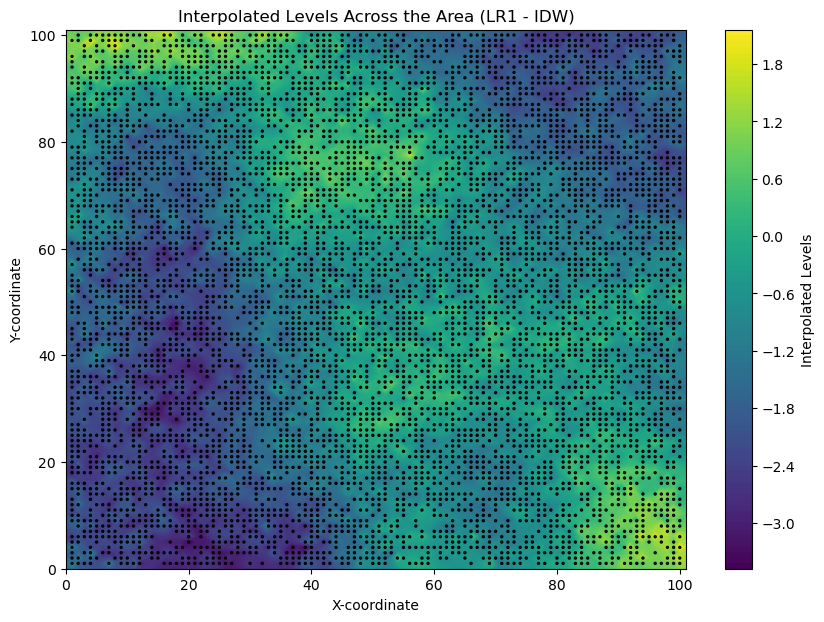

Spatial Interpolation Computation Time: 0.21 seconds


In [68]:
# Using full set: Convert columns to numpy arrays
observed_location_columns = ['x', 'y']
observed_values_column = 'z'
observed_locations = all_df[observed_location_columns].values
observed_values = all_df[observed_values_column].values

# Initialize IDW model
idw_model = ShepardIDWInterpolator(observed_locations, observed_values)

# Start timing spatial interpolation
start_time_interpolation = time.time()

x_min, x_max = observed_locations[:, 0].min() - 1, observed_locations[:, 0].max() + 1
y_min, y_max = observed_locations[:, 1].min() - 1, observed_locations[:, 1].max() + 1
x_range = np.linspace(x_min, x_max, 100)
y_range = np.linspace(y_min, y_max, 100)
x_grid, y_grid = np.meshgrid(x_range, y_range)
grid_points = np.c_[x_grid.ravel(), y_grid.ravel()]

# Interpolate values
interpolated_values = idw_model.__call__(grid_points, power = 2, n_neighbors = 10)
z_grid = interpolated_values.reshape(x_grid.shape)

end_time_interpolation = time.time()  # End timing spatial interpolation

# Visualization
plt.figure(figsize=(10, 7))
plt.contourf(x_grid, y_grid, z_grid, cmap='viridis', levels=100)
plt.colorbar(label='Interpolated Levels')
plt.scatter(all_df['x'], all_df['y'], c=all_df['z'], cmap='viridis', edgecolor='k', label='Observed', s= 2.0)
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
#plt.legend()
plt.title('Interpolated Levels Across the Area (LR1 - IDW)')
plt.show()

print(f"Spatial Interpolation Computation Time: {end_time_interpolation - start_time_interpolation:.2f} seconds")